# Song Information Grabber

The goal is to grab information of the song that could possibly help the Neural Network with weights and etc...

By: 
- Andrew Angulo
- Daniel Ziabicki
- Liam Quinlan

In [18]:
%pip install librosa
%pip install numpy
%pip install pandas
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/Library/Developer/Comm

In [19]:
import os
import json
import math
import librosa
import pandas as pd
import numpy as np
#import scipy.io
import matplotlib.pyplot as plt
from tensorflow import keras

# from scipy.io import wavfile
from os.path import dirname, join as pjoin

---
# Grabbing The Song

In [20]:
# Get the current working directory (where your notebook/script is running)
current_dir = os.getcwd()

# Build the path to the Test_Songs folder
data_dir = pjoin(current_dir, 'Test_Songs')

# Full path to the song
song_path = pjoin(data_dir, 'Bennie And The Jets.wav')

---
# Understanding the data within the Song file

Utilizing the documentation to understand the data from the example song file

[Librosa Documentation](https://librosa.org/doc/latest/index.html)

[I followed this guide](https://www.youtube.com/watch?v=Oa_d-zaUti8&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=11)

In [21]:
import librosa, librosa.display

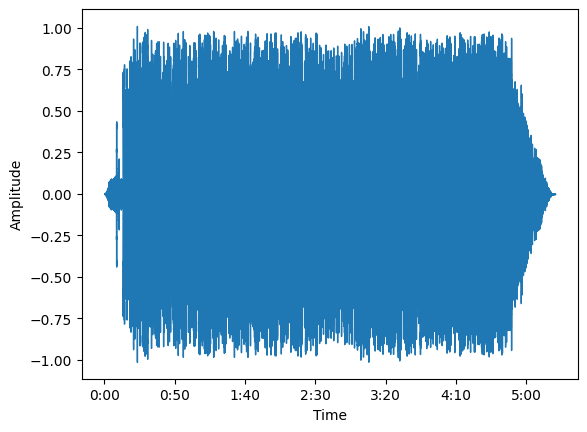

In [22]:
audio_data, sample_rate = librosa.load(song_path, sr=22050)
librosa.display.waveshow(audio_data, sr=sample_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [23]:
fft = np.fft.fft(audio_data)
magnitude = np.abs(fft)
frequency = np.linspace(0, sample_rate, len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]

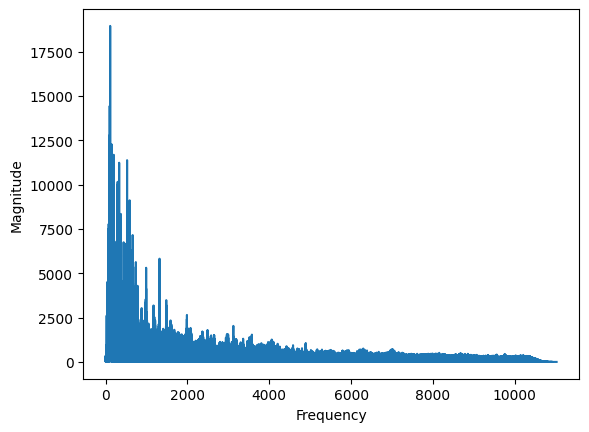

In [24]:
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

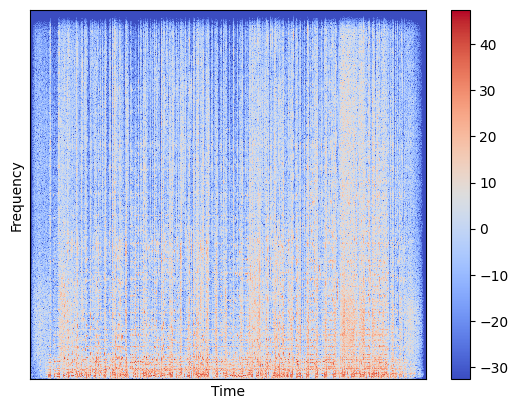

In [25]:
n_fft = 2048 # number of samples
hop_length = 512 # amount we shift each fft to the right


stft = librosa.core.stft(audio_data, hop_length = hop_length, n_fft = n_fft)

spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)


librosa.display.specshow(log_spectrogram, sr = sample_rate, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

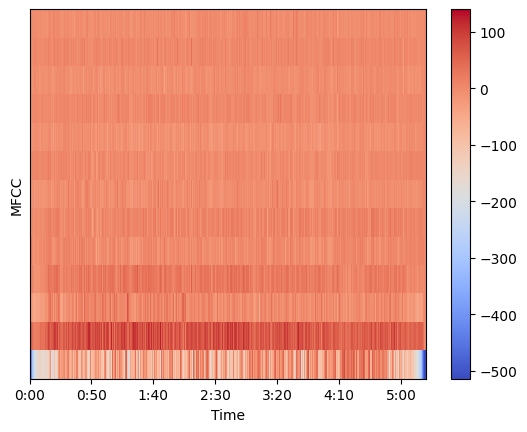

In [26]:
# MFCC
MFCCs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length, x_axis='time')
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()


In [27]:
# Function to preprocess the new song
def preprocess_song(file_path, segment_duration=3):
    SAMPLE_RATE = 22050
    n_mfcc = 13
    n_fft = 2048
    hop_length = 512

    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    signal_length = len(signal)
    duration = signal_length / SAMPLE_RATE
    num_segments = int(duration / segment_duration)
    num_samples_per_segment = int(segment_duration * SAMPLE_RATE)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    song_mfcc = []
    for s in range(num_segments):
        start_sample = num_samples_per_segment * s
        finish_sample = start_sample + num_samples_per_segment

        if finish_sample > len(signal):
            break

        mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                    sr=sr,
                                    n_fft=n_fft,
                                    n_mfcc=n_mfcc,
                                    hop_length=hop_length)
        mfcc = mfcc.T

        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            song_mfcc.append(mfcc.tolist())

    return song_mfcc

In [46]:
# Load the trained model and label mapping
model = keras.models.load_model("genre_classification_model.keras")
with open('label_mapping.json', 'r') as f:
    mapping = json.load(f)


current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'Test_Songs')
file_path = os.path.join(data_dir, 'Come Play.wav')  # The songpath


song_mfcc = preprocess_song(file_path, segment_duration=3)
X_new = np.array(song_mfcc)
predictions = model.predict(X_new)
average_prediction = np.mean(predictions, axis=0)
predicted_index = np.argmax(average_prediction)
predicted_genre = mapping[predicted_index]

print(f"The predicted genre is: {predicted_genre}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
The predicted genre is: hiphop
